In [1]:
#System imports
import math, time

import matplotlib.pyplot as plt

#Helper imports
import numpy as np
import cv2

#Nice printout imports
from termcolor import colored

#TensorFlow
import tensorflow as tf
import keras
from keras import layers

#Kaggle
import kagglehub

#Pandas
import pandas as pd

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.set_visible_devices([], 'GPU')

Num GPUs Available:  0


In [2]:
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Wojtek.gzip'
df_W = pd.read_parquet(file_path)

file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Artur.gzip'
df_A = pd.read_parquet(file_path)
df_A.drop(index=0, inplace=True)

file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Monika.gzip'
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Marcin.gzip'
df_M = pd.read_parquet(file_path)
df_M.drop(index=0, inplace=True)

file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Monika.gzip'
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet.gzip'
df_test = pd.read_parquet(file_path)
df_test.drop(index=0, inplace=True)

features_W = np.asarray(df_W.drop(columns=['date','label']))
features_A = np.asarray(df_A.drop(columns=['label']))
features_M = np.asarray(df_M.drop(columns=['date','label']))
features_test = np.asarray(df_test.drop(columns=['date','label']))

labels_A = np.full((len(features_A),1), 0.0)
labels_W = np.full((len(features_W),1), 1.0)
labels_M = np.full((len(features_M),1), 2.0)
labels_test = np.full((len(features_test),1), 3.0)

In [ ]:
labels = np.concatenate( (labels_A, labels_W, labels_M) )
features = np.concatenate( (features_A, features_W, features_M) )

model = keras.Sequential(
    [
        layers.Input(shape=(features.shape[1],)),
        #layers.Dense(features.shape[1], activation="sigmoid"),
        #layers.Dense(features.shape[1]//2, activation="sigmoid"),
        layers.Dense(features.shape[1]//4, activation="sigmoid"),
        layers.Dense(features.shape[1]//8, activation="sigmoid"),
        layers.Dense(2, activation="sigmoid"),
        layers.Dense(3, activation="linear"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.summary()

history = model.fit(
    features,
    labels,
    batch_size=64,
    epochs=5,
    shuffle=True,
    class_weight = {0:1.0,1:1.0,2:10.0}
)
model.save(filepath="./model_A_vs_W.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 320)            │       409,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           322 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,611 (1.76 MB)

 Trainable params: 461,611 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
  7/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0975 - sparse_categorical_accuracy: 0.5380

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/home/akalinow/scratch/venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_21']
Received: inputs=Tensor(shape=(500, 1280))
  warnings.warn(msg)


A width: 1.0
W width: 1.0
test width: 1.0
A-W distance: 1.4901161e-08


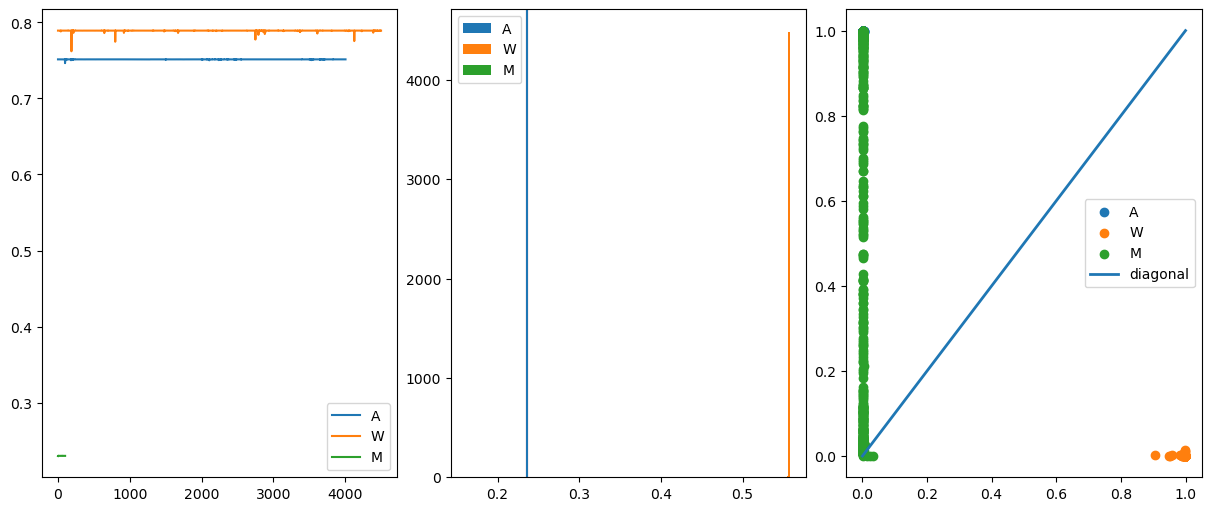

In [182]:
model = keras.saving.load_model("model_A_vs_W.keras")

feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=[model.layers[-2].output],
)

response_A = tf.nn.softmax(model.predict(features_A))
response_W =  tf.nn.softmax(model.predict(features_W))
response_M =  tf.nn.softmax(model.predict(features_M))
response_test =  tf.nn.softmax(model.predict(features_test))

features_2D_A = feature_extractor(features_A)[:,-2:]
features_2D_W = feature_extractor(features_W)[:,-2:]
features_2D_M = feature_extractor(features_test)[:,-2:]

fig, axes = plt.subplots(1,3,layout='constrained', figsize = (12,5))

axes[0].plot(response_A[:,0], label="A")
axes[0].plot(response_W[:,1], label="W")
axes[0].plot(response_M[:,2], label="M")
axes[0].legend();

sigma_A = 1.0 #response_A.std()
sigma_W = 1.0 #response_W.std()
sigma_M = 1.0 #response_test.std()

sigma = np.sqrt(sigma_A**2 + sigma_W**2)
distance = np.mean(response_A/sigma) - np.mean(response_W/sigma)
axes[1].hist(response_A[:,0]/sigma, label="A")
axes[1].hist(response_W[:,1]/sigma, label="W")
axes[1].hist(response_M[:,2]/sigma, label="M")
axes[1].axvline(x=np.mean(response_A/sigma),color="red")
axes[1].axvline(x=np.mean(response_W/sigma))
axes[1].legend();

print(colored("A width:","blue"),sigma_A)
print(colored("W width:","blue"),sigma_W)
print(colored("test width:","blue"),sigma_M)
print(colored("A-W distance:","blue"),np.abs(distance))

axes[2].scatter(features_2D_A[:,0], features_2D_A[:,1], label="A")
axes[2].scatter(features_2D_W[:,0], features_2D_W[:,1], label="W")
axes[2].scatter(features_2D_M[:,0], features_2D_M[:,1], label="M")
axes[2].plot([0,1], [0,1], lw=2, label="diagonal")
axes[2].legend();

tf.Tensor([0.35212463 0.4178267  0.23004869], shape=(3,), dtype=float32)
tf.Tensor([0.751362   0.12949404 0.11914393], shape=(3,), dtype=float32)
tf.Tensor([0.13955945 0.78915715 0.07128334], shape=(3,), dtype=float32)
tf.Tensor([0.7512937  0.12954614 0.11916006], shape=(3,), dtype=float32)


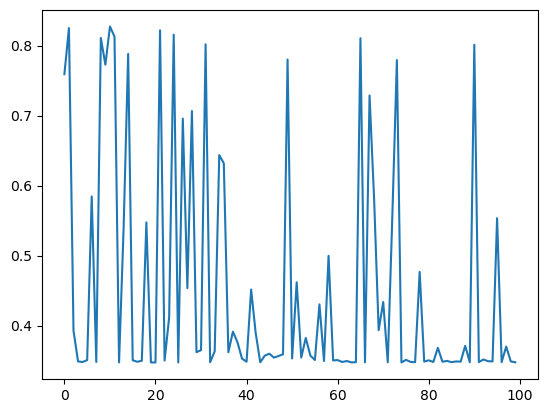

In [181]:
v1 = response_W[:4000,:]
v2 = response_A[:4000,:]

v1 = response_W[:100,:]
v2 = response_test[:100,:]

x = np.sum(v1*v2, axis=1)
x /=  np.sqrt(np.sum(v1**2, axis=1))
x /=  np.sqrt(np.sum(v2**2, axis=1))
plt.plot(x)
print(response_M[20,:])
print(response_A[20,:])
print(response_W[20,:])
print(response_test[20,:])


In [ ]:
last_layer = model.layers[-1]
x = feature_extractor(features_A)[0:1,:].numpy()
print(x[:,-2:])
print("Original features:",last_layer(x))

x[:,-2] = 1
x[:,-1] = 0
print(x[:,-2:])

print("Modified features:",last_layer(x))
#last_layer = model.layers[-1]
#last_layer(feature_extractor(features_A))[0]

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/home/akalinow/scratch/venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(100, 1280))
  warnings.warn(msg)
/home/akalinow/scratch/venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(4500, 1280))
  warnings.warn(msg)


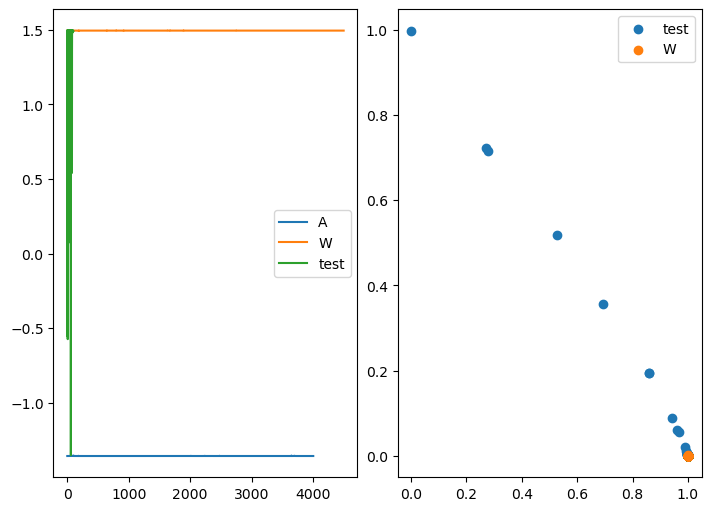

In [8]:
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Marcin.gzip'

df_test = pd.read_parquet(file_path)
df_test.drop(index=0, inplace=True)
features_test = np.asarray(df_test.drop(columns=['date','label']))

model = keras.saving.load_model("model_A_vs_W.keras")

response_A = model.predict(features_A)
response_W = model.predict(features_W)
response_test = model.predict(features_test)

features_2D_test = feature_extractor(features_test)
features_2D_W = feature_extractor(features_W)

fig, axes = plt.subplots(1,2,layout='constrained', figsize = (7,5))

axes[0].plot(response_A, label="A")
axes[0].plot(response_W, label="W")
axes[0].plot(response_test, label="test")
axes[0].legend();

axes[1].scatter(features_2D_test[:,0], features_2D_test[:,1], label="test")
axes[1].scatter(features_2D_W[:,0], features_2D_W[:,1], label="W")
axes[1].legend();

In [ ]:
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Wojtek_1.gzip'
df = pd.read_parquet(file_path)
df.drop(index=0, inplace=True)

file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Wojtek_2.gzip'
df_1 = pd.read_parquet(file_path)
df_1.drop(index=0, inplace=True)

df = pd.concat((df, df_1))
df.to_parquet('df.parquet_Wojtek_3.gzip',compression='gzip')  